In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def image_segmentation(data):
	print("\n........Program Initiated.......\n")
	#src_img = cv2.imread(data, cv2.IMREAD_GRAYSCALE)
	for img in data:
		orig_height, orig_width = img.shape

		print("\n Resizing Image........")
		width = 128
		height = int(width * orig_height / orig_width)
		src_img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)

		print("#---------Image Info:--------#")
		print("\tHeight =", height, "\n\tWidth =", width)
		PIXEL_SET = 255
		kernel_size = 21
		normalized_mean = 20
		bin_img = cv2.adaptiveThreshold(img, PIXEL_SET, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, kernel_size,
										normalized_mean)

		print("Noise Removal")
		kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
		final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
		contr_retrival = final_thr.copy()

In [ ]:
!pip3 install patool
import patoolib
patoolib.extract_archive("drive/MyDrive/data.rar")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
patool: Extracting drive/MyDrive/data.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/data.rar
patool:     with cwd='./Unpack_gt21b3jd'
patool: ... drive/MyDrive/data.rar extracted to `data' (local file exists).


'data'

In [ ]:
import os
import tensorflow as tf
import cv2
import numpy as np
import sklearn

path = 'extracted_images'
#files=os.listdir(path)

use_number = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
use_symbol = ['+', '-', 'times', 'div', '!', '(', ')', 'pi', 'log', 'sin', 'cos', 'tan']

def load_images_from_folder(dir):
    train_data=[]
    label = []
    for label_name in os.listdir(dir):
      if (label_name not in use_number) and (label_name not in use_symbol):
        continue
      folder = dir + "/" + label_name
      for filename in os.listdir(folder):
          #print(os.path.join(folder,filename))
          img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
          img = ~img
          train_data.append(img)
          label.append(label_name)
          if img is not None:
              ret,thresh=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
              ret,ctrs,ret=cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
              cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
              w=int(28)
              h=int(28)
              maxi=0
              for c in cnt:
                  x,y,w,h=cv2.boundingRect(c)
                  maxi=max(w*h,maxi)
                  if maxi==w*h:
                      x_max=x
                      y_max=y
                      w_max=w
                      h_max=h
              im_crop= thresh[y_max:y_max+h_max+10, x_max:x_max+w_max+10]
              im_resize = cv2.resize(im_crop,(28,28))
              im_resize=np.reshape(im_resize,(784,1))
              train_data.append(im_resize)

    return train_data, label

data, label = load_images_from_folder(path)
print(len(label))


print(np.array(label).shape)
print(np.array(data).shape)

shuffle_img, shuffle_label = sklearn.utils.shuffle(np.array(data), np.array(label))

print(shuffle_label)


#image_segmentation()

201496
(201496,)
(201496, 45, 45)
['1' 'sin' ')' ... ')' '1' 'log']


(100000, 45, 45)
(100000,)
!          635
(         7052
)         7181
+        12568
-        16934
0         3370
1        12940
2        12983
3         5502
4         3700
5         1768
6         1514
7         1395
8         1552
9         1884
cos       1410
div        459
log       1001
pi        1170
sin       2176
tan       1202
times     1604
dtype: int64


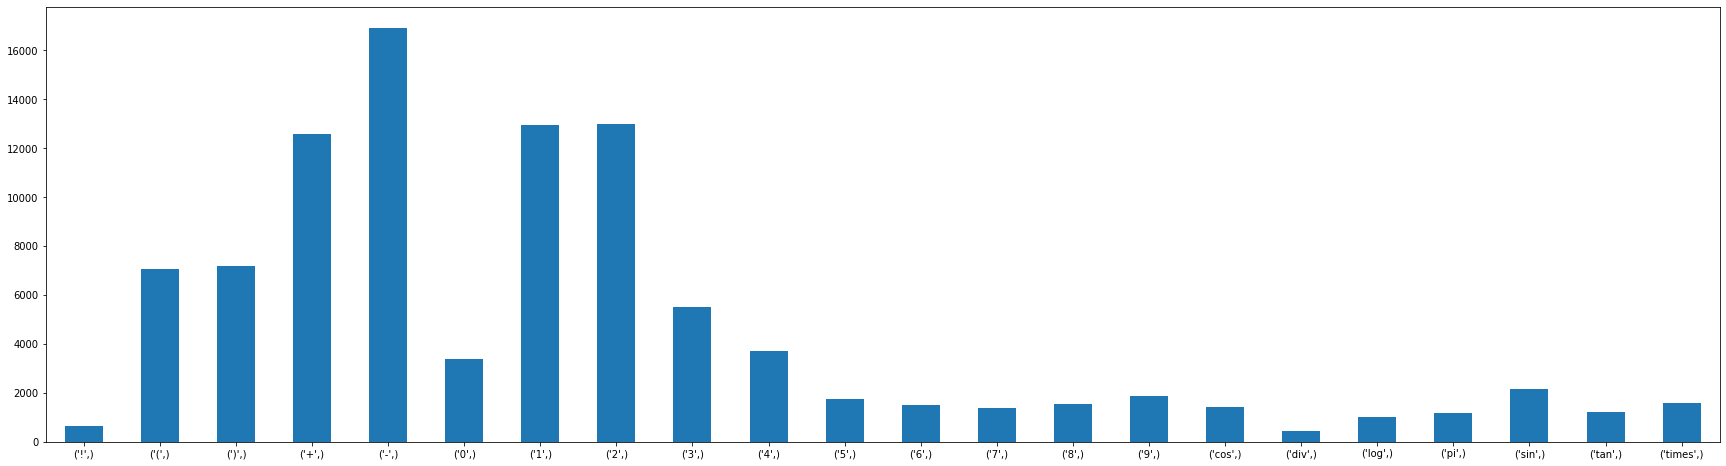

In [ ]:
from sklearn.utils import resample

X, y = resample(shuffle_img, shuffle_label, n_samples = 100000)

print(X.shape)
print(y.shape)

import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (30, 8)
labels = pd.DataFrame(y)
count = labels.value_counts().sort_index()
print(count)
cnt = count.to_dict()
count = pd.Series(cnt)
bar = count.plot(kind='bar')
bar.set_xticklabels(labels = count.index)
plt.xticks(rotation = 0)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labelencoder.fit(np.ravel(shuffle_label))
label_encoded = labelencoder.transform(np.ravel(shuffle_label))

#label_encoded_t = labelencoder.transform(np.ravel(test_label))

encoded = tf.keras.utils.to_categorical(label_encoded, num_classes=22)
#test_encoded = tf.keras.utils.to_categorical(label_encoded_t, num_classes=6)


le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)
print(label_encoded)

{'!': 0, '(': 1, ')': 2, '+': 3, '-': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, 'cos': 15, 'div': 16, 'log': 17, 'pi': 18, 'sin': 19, 'tan': 20, 'times': 21}
[ 6 19  2 ...  2  6 17]


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.layers import Input,Activation,Add
import tensorflow.keras.layers as layers
import keras

checkpointer = ModelCheckpoint('mdl_wts_race.hdf5', monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=EarlyStopping(patience=30, monitor='val_loss',restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, epsilon=1e-4, mode='auto')
callback_list=[checkpointer,Early_stop, reduce_lr_loss]

kf = KFold(n_splits=5, shuffle=True)

cnn_cm = np.zeros((22, 2, 2))
cnn_accuracy = 0
cnn_recall = 0
cnn_precision = 0

for train_index, test_index in kf.split(shuffle_img):

  model_ = Sequential()
  model_.add(Input(shape=(45,45,1)))
  #model_.add(data_augmentation)
  model_.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
  model_.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
  model_.add(MaxPooling2D(pool_size=(2, 2)))
  model_.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model_.add(MaxPooling2D(pool_size=(2, 2)))
  model_.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model_.add(MaxPooling2D(pool_size=(2, 2)))
  #model_.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  #model_.add(MaxPooling2D(pool_size=(2, 2)))
  model_.add(Flatten())
  #model_.add(Dense(1024, activation='relu'))
  model_.add(Dense(22, activation='softmax'))

  #model_ = Model(input, output)
  model_.compile(loss=["categorical_crossentropy"], optimizer="Adam", metrics=["accuracy"])
  hist = model_.fit(shuffle_img[train_index],encoded[train_index], validation_data=(shuffle_img[test_index], encoded[test_index]), batch_size=64,epochs=30,callbacks=[callback_list])

  tmp = model_.predict(shuffle_img[test_index])

  cnn_cm = np.add(cnn_cm, multilabel_confusion_matrix(np.argmax(encoded[test_index], axis = 1), np.argmax(tmp, axis = 1)))
  cnn_accuracy += accuracy_score(np.argmax(encoded[test_index], axis = 1), np.argmax(tmp, axis = 1))
  cnn_recall += recall_score(np.argmax(encoded[test_index], axis = 1), np.argmax(tmp, axis = 1), average=None)
  cnn_precision += precision_score(np.argmax(encoded[test_index], axis = 1), np.argmax(tmp, axis = 1), average=None)

cnn_cm /= 5 
#np.round(cm)
cnn_accuracy /= 5
cnn_recall /= 5
cnn_precision /= 5
print(cnn_cm)
print("cnn accuracy score: ", cnn_accuracy)
print("cnn recall score: ", cnn_recall)
print("cnn presion score: ", cnn_precision)

Epoch 1/30
2519/2519 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9286
Epoch 1: val_loss improved from inf to 0.12613, saving model to mdl_wts_race.hdf5
2519/2519 [==============================] - 14s 5ms/step - loss: 0.2489 - accuracy: 0.9286 - val_loss: 0.1261 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 2/30
2512/2519 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.9700
Epoch 2: val_loss improved from 0.12613 to 0.09559, saving model to mdl_wts_race.hdf5
2519/2519 [==============================] - 13s 5ms/step - loss: 0.1009 - accuracy: 0.9700 - val_loss: 0.0956 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 3/30
2509/2519 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9767
Epoch 3: val_loss improved from 0.09559 to 0.07796, saving model to mdl_wts_race.hdf5
2519/2519 [==============================] - 12s 5ms/step - loss: 0.0754 - accuracy: 0.9767 - val_loss: 0.0780 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 4/30


In [ ]:
print(model_.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 45, 45, 1)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 43, 43, 16)        160       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 21, 21, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 19, 19, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 7, 7, 64)        

In [ ]:
model_json = model_.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_.save_weights("model.h5")

In [ ]:
from tensorflow import keras

def predict(symbol):
  model = keras.models.load_model('mdl_wts_race.hdf5')
  pred = model.predict(symbol)
  return pred